## Variáveis agregadas (2010 a 2017)

### Bibliotecas e bases de dados

In [13]:
# Importar bibliotecas
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import recall_score, classification_report, make_scorer
from skopt import BayesSearchCV
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from treeinterpreter import treeinterpreter as ti
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel

#Estilizar conteúdo
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def estilo_tabelas(df, max_altura='300px', casas_decimais=3):
    return (
        df.style.set_table_styles(
            [
                {'selector': 'thead th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('border-bottom', '2px solid #007BFF')]},
                {'selector': 'td', 'props': [('font-size', '10px'), ('text-align', 'center'), ('max-height', '40px'), ('white-space', 'nowrap'), ('text-overflow', 'ellipsis'), ('overflow', 'hidden'), ('max-width', '100px')]},
                {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
                {'selector': 'table', 'props': [('width', '90%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]},
                {'selector': 'td, th', 'props': [('border', '1px solid #666')]},
            ]
        ).set_properties(
            **{'border-color': 'darkgray', 'border-style': 'solid', 'border-width': '1px'}
        ).set_table_attributes(
            f'style="height:auto; overflow:auto; max-height:{max_altura}; display:block;"'  
        ).format(
            precision=casas_decimais  
        )
    )


object_columns = ['Protocolo_S2iD', 'Nome_Municipio', 'Sigla_UF', 'regiao',
                  'Setores Censitários', 'Status', 'DH_Descricao', 'DM_Descricao',
                  'DA_Descricao', 'DA_Polui/cont da água', 'DA_Polui/cont do ar',
                  'DA_Polui/cont do solo', 'DA_Dimi/exauri hídrico',
                  "DA_Incêndi parques/APA's/APP's", 'PEPL_Descricao', 'PEPR_Descricao',
                  'Categoria', 'Grupo', 'Subgrupo', 'Tipo', 'Subtipo']

dtype = {col: 'object' for col in object_columns}

df_eventos_2010_1 = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_2010_2017_modelo1.csv",
    sep=';',
    decimal=',')

# Remover linhas com dados ausentes

df_eventos_2010_1 = df_eventos_2010_1.dropna()

estilo_tabelas(df_eventos_2010_1.head(5))

# Remover registros em que todos os dados informados são 0

df_eventos_2010_1 = df_eventos_2010_1[
    ~((df_eventos_2010_1['DH_total_danos_humanos'] == 0) &
      (df_eventos_2010_1['DM_total_danos_materiais'] == 0) &
      (df_eventos_2010_1['PEPL_total_publico'] == 0) &
      (df_eventos_2010_1['PEPR_total_privado'] == 0))
]

### Modelo base

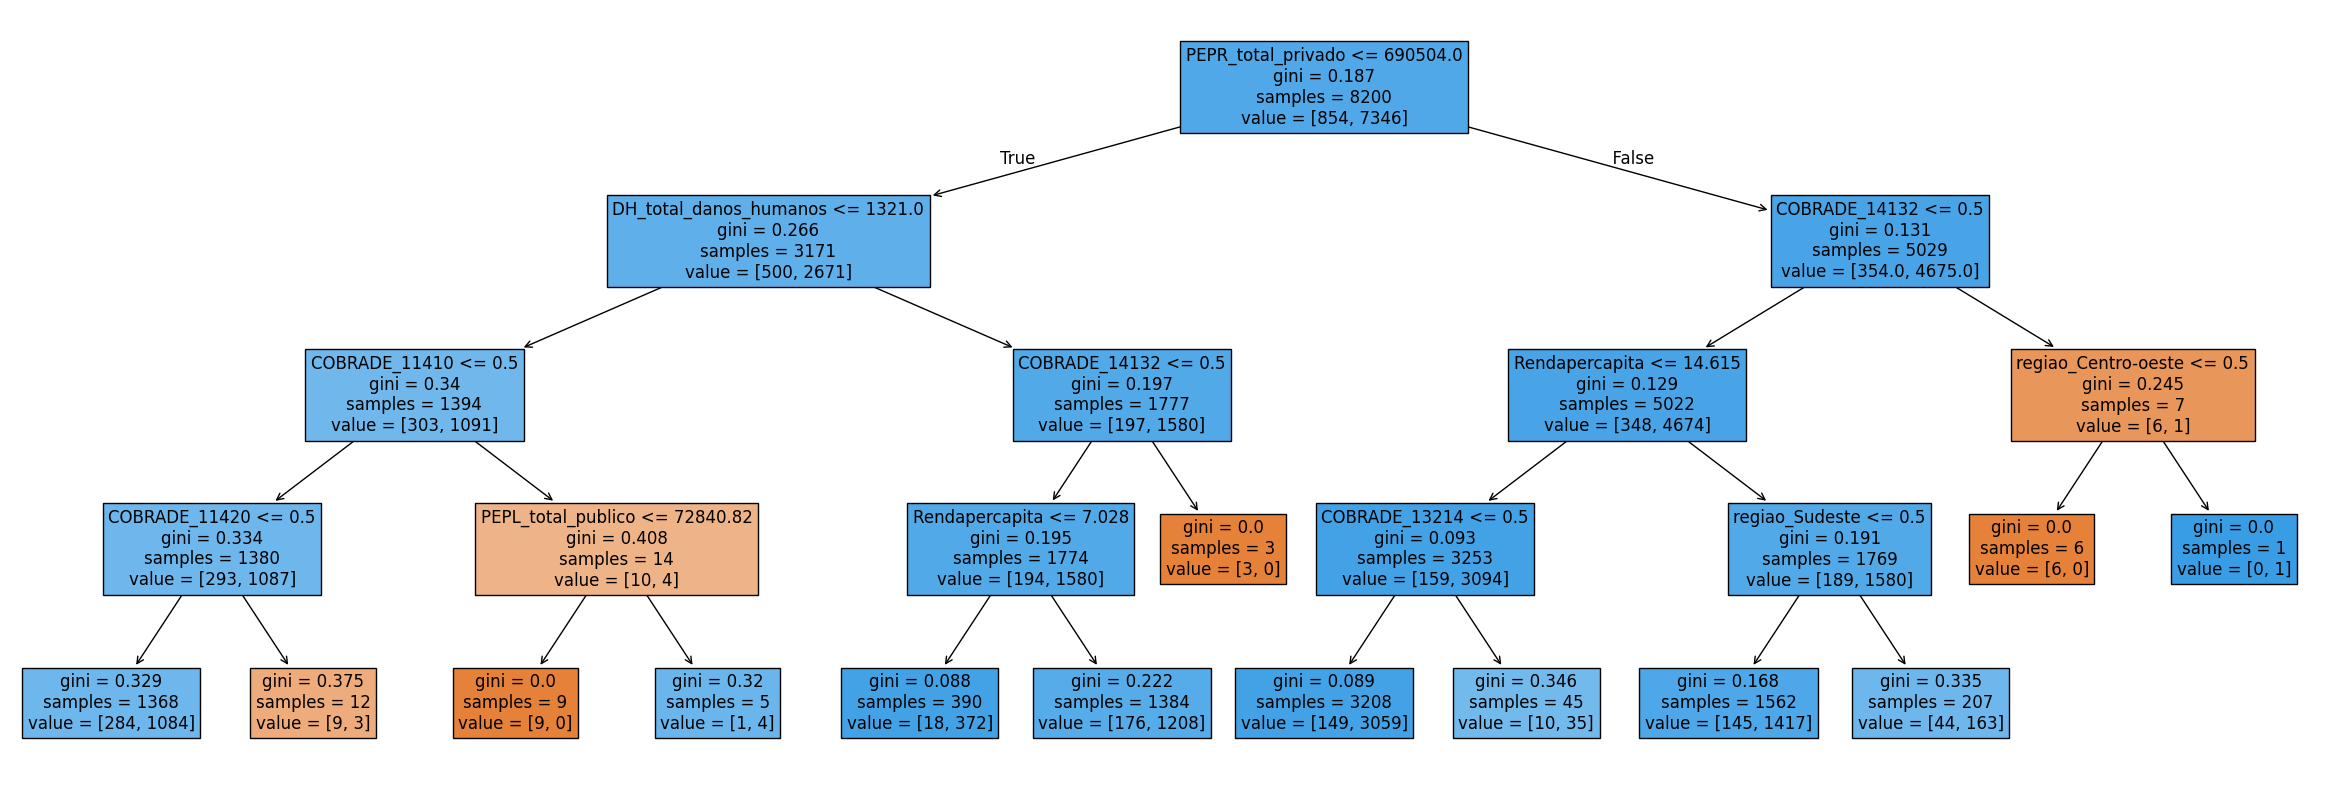

In [14]:
# Dividir dados em treino e teste
X_modelo1_2010_2017, y_modelo1_2010_2017 = df_eventos_2010_1.drop('Status', axis=1), df_eventos_2010_1['Status']

X_train_modelo1_2010_2017, X_test_modelo1_2010_2017, y_train_modelo1_2010_2017, y_test_modelo1_2010_2017 = train_test_split(
    X_modelo1_2010_2017, y_modelo1_2010_2017, test_size=0.2, random_state=1)

# Árvore de decisão
clf_modelo1_2010_2017 = DecisionTreeClassifier(max_depth=4).fit(X_train_modelo1_2010_2017, y_train_modelo1_2010_2017)

# Fazer predições
y_pred_modelo1_2010_2017 = clf_modelo1_2010_2017.predict(X_test_modelo1_2010_2017)

# Mostrar a árvore de decisão
plt.figure(figsize=(30,10))
plot_tree(clf_modelo1_2010_2017, filled=True, fontsize=12, feature_names=X_modelo1_2010_2017.columns)
plt.show()

In [15]:
# Gerar e imprimir o classification report
classification_report_modelo1_2010_2017 = classification_report(
    y_test_modelo1_2010_2017, 
    y_pred_modelo1_2010_2017, 
    digits=6, 
    target_names=['Não reconhecido', 'Reconhecido']
)

print("Classification report variáveis agregadas 2010-2017: \n", classification_report_modelo1_2010_2017)

Classification report variáveis agregadas 2010-2017: 
                  precision    recall  f1-score   support

Não reconhecido   0.714286  0.020747  0.040323       241
    Reconhecido   0.884540  0.998895  0.938246      1810

       accuracy                       0.883959      2051
      macro avg   0.799413  0.509821  0.489284      2051
   weighted avg   0.864535  0.883959  0.832737      2051



In [16]:
# Usar o treeinterpreter para explicar uma previsão
instance_modelo1_2010_2017 = X_test_modelo1_2010_2017.iloc[[0]].values  # Explicando a primeira instância do conjunto de teste
prediction_modelo1_2010_2017, bias_modelo1_2010_2017, contributions_modelo1_2010_2017 = ti.predict(clf_modelo1_2010_2017, instance_modelo1_2010_2017)

# Criar DataFrame para mostrar a contribuição de cada característica
num_features_modelo1_2010_2017 = contributions_modelo1_2010_2017[0].shape[0]
feature_contributions_modelo1_2010_2017 = pd.DataFrame({
    'Feature': X_modelo1_2010_2017.columns[:num_features_modelo1_2010_2017],  # Ajustar nomes das features
    'Contribution': contributions_modelo1_2010_2017[0][:, 1]  # Seleciona a coluna da classe positiva (1)
})
feature_contributions_modelo1_2010_2017['Absolute Contribution'] = feature_contributions_modelo1_2010_2017['Contribution'].abs()

# Ordenar as contribuições
feature_contributions_modelo1_2010_2017 = feature_contributions_modelo1_2010_2017.sort_values(by='Absolute Contribution', ascending=False)

# Mostrar a previsão, o valor de bias e as contribuições
print(f"Previsão do modelo: {prediction_modelo1_2010_2017[0][1]:.4f}")
print(f"Valor de bias (média): {bias_modelo1_2010_2017[0][1]:.4f}")
print("\nContribuições das características:")
print(feature_contributions_modelo1_2010_2017)

Previsão do modelo: 0.8728
Valor de bias (média): 0.8959

Contribuições das características:
                     Feature  Contribution  Absolute Contribution
3         PEPR_total_privado     -0.053533               0.053533
0     DH_total_danos_humanos      0.046818               0.046818
54            Rendapercapita     -0.017810               0.017810
40             COBRADE_14132      0.001504               0.001504
2         PEPL_total_publico      0.000000               0.000000
4        regiao_Centro-oeste      0.000000               0.000000
31             COBRADE_13213      0.000000               0.000000
32             COBRADE_13214      0.000000               0.000000
33             COBRADE_13215      0.000000               0.000000
34             COBRADE_13310      0.000000               0.000000
35             COBRADE_13321      0.000000               0.000000
36             COBRADE_13322      0.000000               0.000000
37             COBRADE_14110      0.000000       

### Modelo com busca de hiperparâmetros e balanceamento SMOTE

In [17]:
# Aplicar SMOTE para balanceamento
smote_balanceador = SMOTE(random_state=1)

# Dividir dados em treino e teste
X_train_2010_2017_smote, X_test_2010_2017_smote, y_train_2010_2017_smote, y_test_2010_2017_smote = train_test_split(
    df_eventos_2010_1.drop('Status', axis=1), df_eventos_2010_1['Status'], test_size=0.2, random_state=1
)

# Balancear as classes usando SMOTE
X_train_2010_2017_smote, y_train_2010_2017_smote = smote_balanceador.fit_resample(X_train_2010_2017_smote, y_train_2010_2017_smote)

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes_smote = {
    'decisiontree__max_depth': [3, 5, 7, 9, 12, 15, 20],  # Profundidade máxima da árvore
    'decisiontree__min_samples_split': [2, 5, 10, 20],  # Número mínimo de amostras para dividir um nó
    'decisiontree__min_samples_leaf': [1, 2, 4, 6],  # Número mínimo de amostras em uma folha
    'decisiontree__criterion': ['gini', 'entropy']  # Critério de divisão
}

# Criar pipeline com RobustScaler e DecisionTreeClassifier
pipeline_tree_smote = Pipeline([
    ('scaler', RobustScaler()),  # Utilizando RobustScaler para padronização
    ('decisiontree', DecisionTreeClassifier(random_state=1))
])

# Definir o scorer como recall_score
scorer_smote = make_scorer(recall_score)

# Realizar a busca bayesiana com validação cruzada usando recall como métrica
bayes_search_tree_smote = BayesSearchCV(
    pipeline_tree_smote,
    search_spaces=param_grid_bayes_smote,
    n_iter=30,
    cv=3,
    scoring=scorer_smote,  # Usando recall_score como métrica de avaliação
    n_jobs=-1,
    random_state=1
)

# Ajustar a busca bayesiana ao conjunto de treino balanceado com SMOTE
bayes_search_tree_smote.fit(X_train_2010_2017_smote, y_train_2010_2017_smote)

# Melhor modelo encontrado
best_tree_model_smote = bayes_search_tree_smote.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros (SMOTE): {bayes_search_tree_smote.best_params_}")

# Fazer previsões com o conjunto de teste
y_pred_tree_smote = best_tree_model_smote.predict(X_test_2010_2017_smote)

# Relatório de classificação
classification_report_tree_smote = classification_report(
    y_test_2010_2017_smote, 
    y_pred_tree_smote, 
    target_names=['Não reconhecido', 'Reconhecido'], 
    digits=6
)

print("Relatório de Classificação (SMOTE):")
print(classification_report_tree_smote)

Melhores hiperparâmetros (SMOTE): OrderedDict([('decisiontree__criterion', 'entropy'), ('decisiontree__max_depth', 7), ('decisiontree__min_samples_leaf', 6), ('decisiontree__min_samples_split', 20)])
Relatório de Classificação (SMOTE):
                 precision    recall  f1-score   support

Não reconhecido   0.187970  0.207469  0.197239       241
    Reconhecido   0.892997  0.880663  0.886787      1810

       accuracy                       0.801560      2051
      macro avg   0.540484  0.544066  0.542013      2051
   weighted avg   0.810154  0.801560  0.805763      2051



### Modelo com busca de hiperparâmetros e balanceamento das variáveis target por pesos

Melhores hiperparâmetros (balanceado): OrderedDict([('decisiontree__criterion', 'entropy'), ('decisiontree__max_depth', 3), ('decisiontree__min_samples_leaf', 2), ('decisiontree__min_samples_split', 2)])


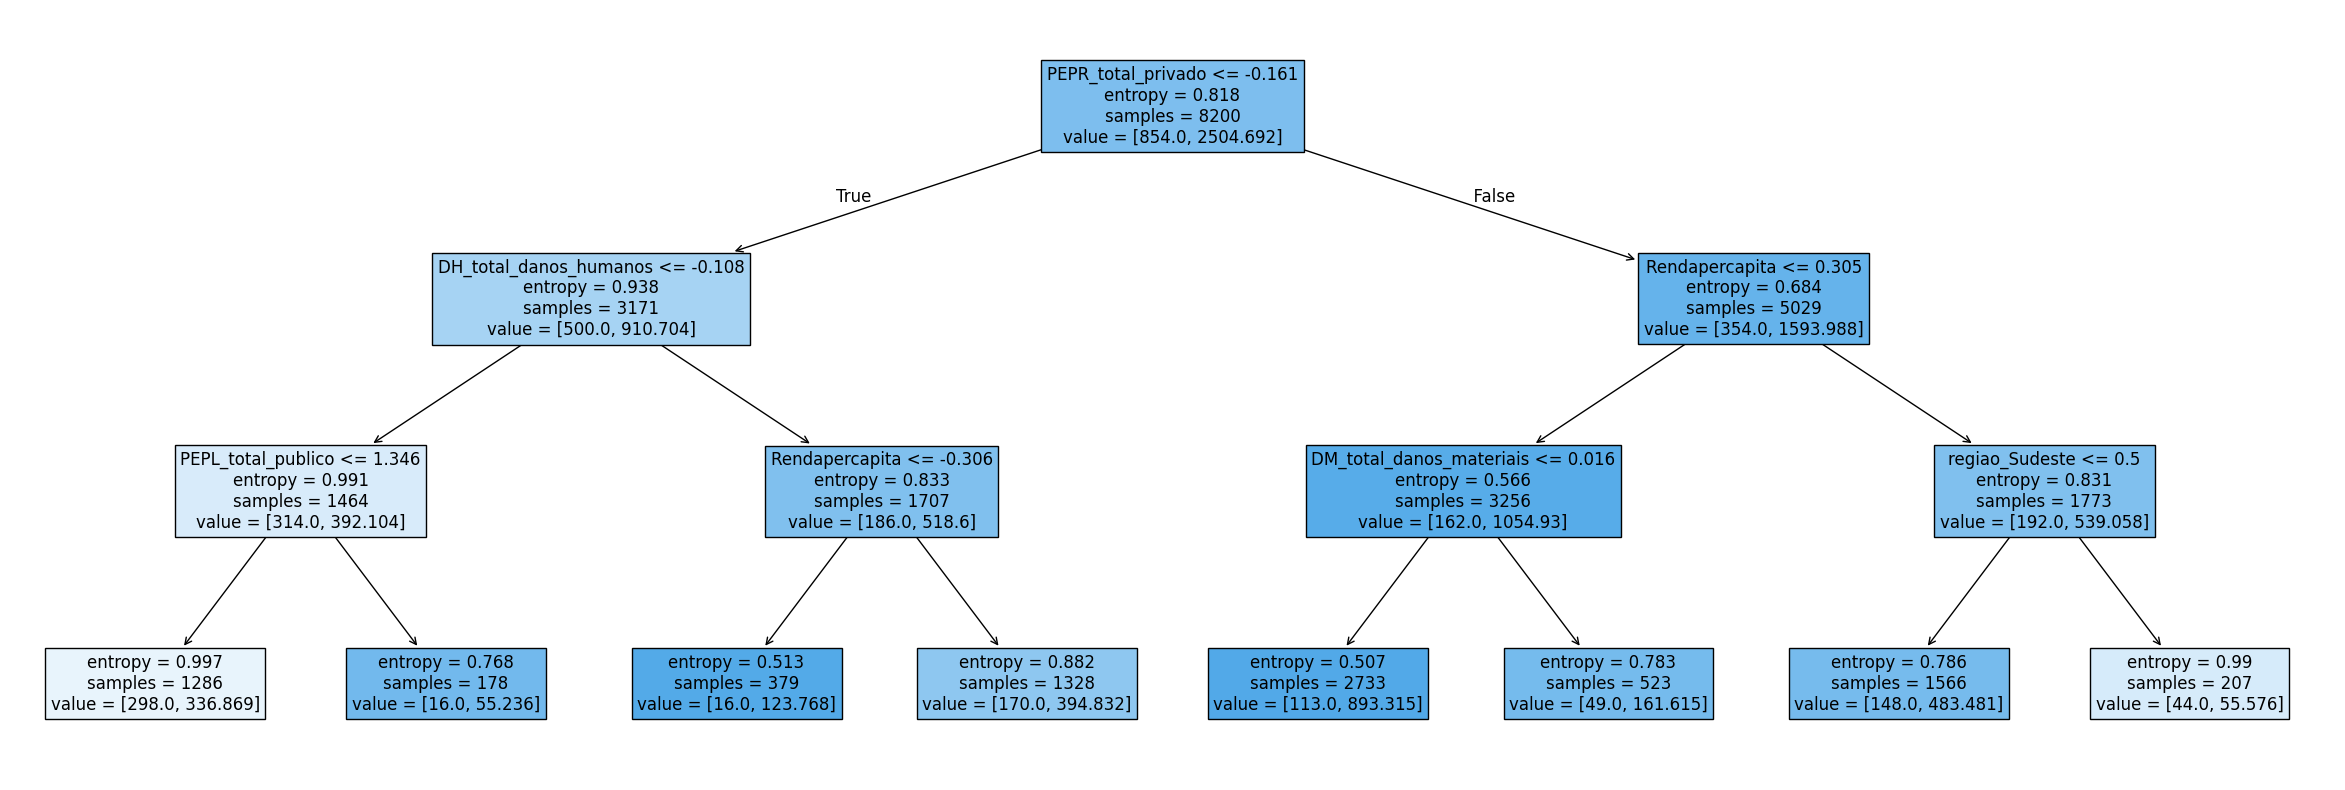

In [18]:
# Dividir dados em treino e teste (modelo com balanceamento)
X_train_2010_2017_balanceado, X_test_2010_2017_balanceado, y_train_2010_2017_balanceado, y_test_2010_2017_balanceado = train_test_split(
    df_eventos_2010_1.drop('Status', axis=1), df_eventos_2010_1['Status'], test_size=0.2, random_state=1
)

# Calcular scale_pos_weight manualmente para balanceamento
scale_pos_weight_balanceado = np.sqrt(y_train_2010_2017_balanceado.value_counts()[0] / y_train_2010_2017_balanceado.value_counts()[1])

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes_balanceado = {
    'decisiontree__max_depth': [3, 5, 7, 9, 12, 15, 20],  # Profundidade máxima da árvore
    'decisiontree__min_samples_split': [2, 5, 10, 20],  # Número mínimo de amostras para dividir um nó
    'decisiontree__min_samples_leaf': [1, 2, 4, 6],  # Número mínimo de amostras em uma folha
    'decisiontree__criterion': ['gini', 'entropy']  # Critério de divisão
}

# Criar pipeline com RobustScaler e DecisionTreeClassifier
pipeline_tree_balanceado = Pipeline([
    ('scaler', RobustScaler()),  # Utilizando RobustScaler para padronização
    ('decisiontree', DecisionTreeClassifier(
        random_state=1,
        class_weight={0: 1, 1: scale_pos_weight_balanceado}  # Balanceamento manual das classes
    ))
])

# Definir o scorer como recall_score
scorer_balanceado = make_scorer(recall_score)

# Realizar a busca bayesiana com validação cruzada usando recall como métrica
bayes_search_tree_balanceado = BayesSearchCV(
    pipeline_tree_balanceado,
    search_spaces=param_grid_bayes_balanceado,
    n_iter=30,
    cv=3,
    scoring=scorer_balanceado,  # Usando recall_score como métrica de avaliação
    n_jobs=-1,
    random_state=1
)

# Ajustar a busca bayesiana ao conjunto de treino
bayes_search_tree_balanceado.fit(X_train_2010_2017_balanceado, y_train_2010_2017_balanceado)

# Melhor modelo encontrado
best_tree_model_balanceado = bayes_search_tree_balanceado.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros (balanceado): {bayes_search_tree_balanceado.best_params_}")

# Fazer previsões com o conjunto de teste
y_pred_tree_balanceado = best_tree_model_balanceado.predict(X_test_2010_2017_balanceado)

# Mostrar a árvore de decisão do modelo com balanceamento
plt.figure(figsize=(30,10))
plot_tree(
    best_tree_model_balanceado.named_steps['decisiontree'],  # Seleciona o DecisionTreeClassifier do pipeline
    filled=True, 
    fontsize=12, 
    feature_names=X_train_2010_2017_balanceado.columns
)
plt.show()

In [19]:
# Relatório de classificação
classification_report_tree_balanceado = classification_report(
    y_test_2010_2017_balanceado, 
    y_pred_tree_balanceado, 
    target_names=['Não reconhecido', 'Reconhecido'], 
    digits=6
)

print("Relatório de Classificação (balanceado pesos):")
print(classification_report_tree_balanceado)

Relatório de Classificação (balanceado pesos):
                 precision    recall  f1-score   support

Não reconhecido   0.000000  0.000000  0.000000       241
    Reconhecido   0.882496  1.000000  0.937581      1810

       accuracy                       0.882496      2051
      macro avg   0.441248  0.500000  0.468790      2051
   weighted avg   0.778800  0.882496  0.827412      2051



### Modelo com busca de hiperparâmetros, balanceamento das variáveis target por pesos e seleção de features

In [20]:
# Dividir dados em treino e teste (modelo com balanceamento)
X_train_2010_2017_balanceado_vars, X_test_2010_2017_balanceado_vars, y_train_2010_2017_balanceado_vars, y_test_2010_2017_balanceado_vars = train_test_split(
    df_eventos_2010_1.drop('Status', axis=1), df_eventos_2010_1['Status'], test_size=0.2, random_state=1
)

# Calcular scale_pos_weight manualmente para balanceamento
scale_pos_weight_balanceado_vars = np.sqrt(y_train_2010_2017_balanceado_vars.value_counts()[0] / y_train_2010_2017_balanceado_vars.value_counts()[1])

# Criar modelo inicial para estimar importância das features
initial_tree = DecisionTreeClassifier(random_state=1, class_weight={0: 1, 1: scale_pos_weight_balanceado_vars})

# Treinar o modelo inicial
initial_tree.fit(X_train_2010_2017_balanceado_vars, y_train_2010_2017_balanceado_vars)

# Obter a importância das features e calcular a média
feature_importances = initial_tree.feature_importances_
mean_importance = np.mean(feature_importances)

# Selecionar variáveis que têm importância acima da média
selector = SelectFromModel(initial_tree, threshold=mean_importance, prefit=True)
X_train_2010_2017_selected_vars = selector.transform(X_train_2010_2017_balanceado_vars)
X_test_2010_2017_selected_vars = selector.transform(X_test_2010_2017_balanceado_vars)

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes_balanceado_vars = {
    'decisiontree__max_depth': [3, 5, 7, 9, 12, 15, 20],  # Profundidade máxima da árvore
    'decisiontree__min_samples_split': [2, 5, 10, 20],  # Número mínimo de amostras para dividir um nó
    'decisiontree__min_samples_leaf': [1, 2, 4, 6],  # Número mínimo de amostras em uma folha
    'decisiontree__criterion': ['gini', 'entropy']  # Critério de divisão
}

# Criar pipeline com RobustScaler e DecisionTreeClassifier
pipeline_tree_balanceado_vars = Pipeline([
    ('scaler', RobustScaler()),  # Utilizando RobustScaler para padronização
    ('decisiontree', DecisionTreeClassifier(
        random_state=1,
        class_weight={0: 1, 1: scale_pos_weight_balanceado_vars}  # Balanceamento manual das classes
    ))
])

# Definir o scorer como recall_score
scorer_balanceado_vars = make_scorer(recall_score)

# Realizar a busca bayesiana com validação cruzada usando recall como métrica
bayes_search_tree_balanceado_vars = BayesSearchCV(
    pipeline_tree_balanceado_vars,
    search_spaces=param_grid_bayes_balanceado_vars,
    n_iter=30,
    cv=3,
    scoring=scorer_balanceado_vars,  # Usando recall_score como métrica de avaliação
    n_jobs=-1,
    random_state=1
)

# Ajustar a busca bayesiana ao conjunto de treino balanceado com as variáveis selecionadas
bayes_search_tree_balanceado_vars.fit(X_train_2010_2017_selected_vars, y_train_2010_2017_balanceado_vars)

# Melhor modelo encontrado
best_tree_model_balanceado_vars = bayes_search_tree_balanceado_vars.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros (balanceado com variáveis selecionadas): {bayes_search_tree_balanceado_vars.best_params_}")

# Fazer previsões com o conjunto de teste
y_pred_tree_balanceado_vars = best_tree_model_balanceado_vars.predict(X_test_2010_2017_selected_vars)

# Relatório de classificação
classification_report_tree_balanceado_vars = classification_report(
    y_test_2010_2017_balanceado_vars, 
    y_pred_tree_balanceado_vars, 
    target_names=['Não reconhecido', 'Reconhecido'], 
    digits=6
)

print("Relatório de Classificação (balanceado com variáveis selecionadas):")
print(classification_report_tree_balanceado_vars)

Melhores hiperparâmetros (balanceado com variáveis selecionadas): OrderedDict([('decisiontree__criterion', 'entropy'), ('decisiontree__max_depth', 3), ('decisiontree__min_samples_leaf', 2), ('decisiontree__min_samples_split', 2)])
Relatório de Classificação (balanceado com variáveis selecionadas):
                 precision    recall  f1-score   support

Não reconhecido   0.000000  0.000000  0.000000       241
    Reconhecido   0.882496  1.000000  0.937581      1810

       accuracy                       0.882496      2051
      macro avg   0.441248  0.500000  0.468790      2051
   weighted avg   0.778800  0.882496  0.827412      2051



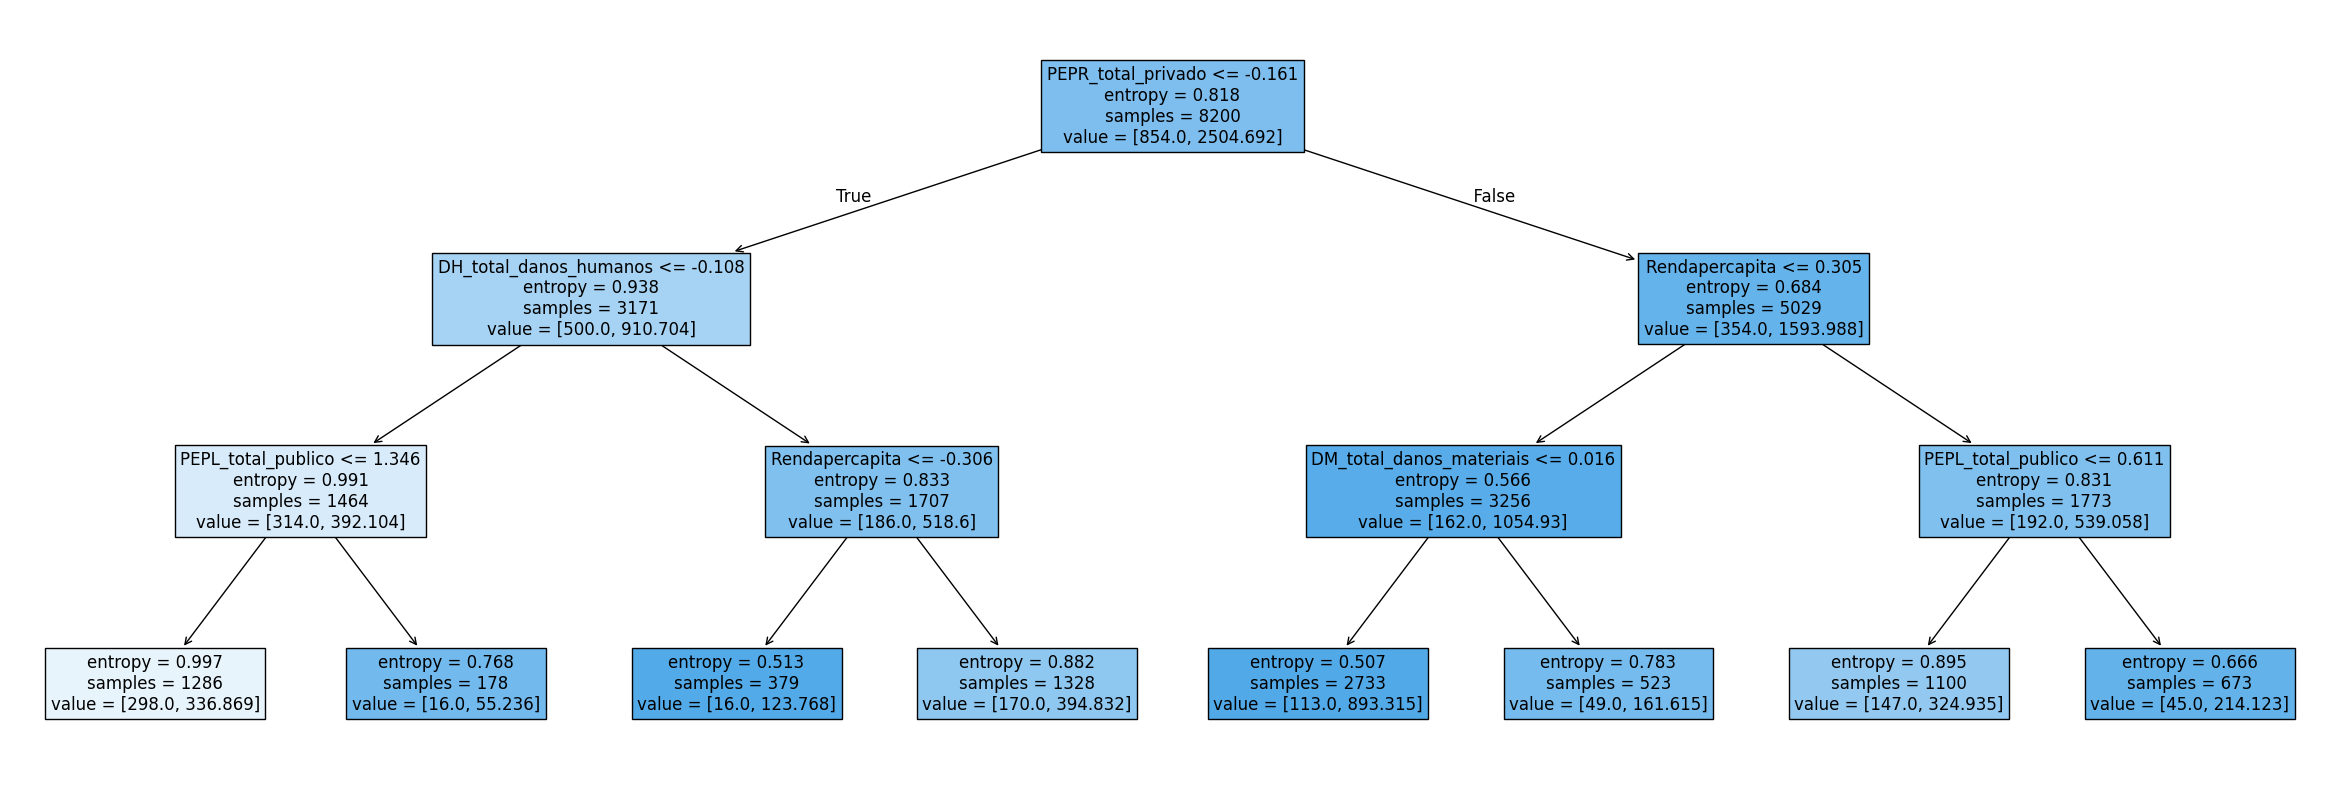

In [21]:
plt.figure(figsize=(30,10))
plot_tree(
    best_tree_model_balanceado_vars.named_steps['decisiontree'],  # Seleciona o DecisionTreeClassifier do pipeline
    filled=True, 
    fontsize=12, 
    feature_names=X_train_2010_2017_balanceado_vars.columns[selector.get_support()]  # Nomes das features selecionadas
)
plt.show()